# WIP: sandbox for experiments

In [160]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# This variable should be set to false, unless you are running this notebook without the
# generated datasets
first_time = False

I'm having problems with the pattern

`frame["col"] = new_value`

It always throws warnings, according to SO, it seems to be a viable option to switch the warnings off.
https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [161]:
pd.options.mode.chained_assignment = None  # default='warn'

Remember, we have computed the song word count at three levels of "swear word categories":

In [162]:
offensiveness_rating = pd.read_pickle("../pickles/offensiveness_rating_structured")
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

Now, the problem is that we have tuples as index but we would like to have all these categories in different columns. So we do some processing to take care of that:

In [163]:
def process_tuple(t):
    
    def process_tuple_elem(elem):
        if elem == "nan":
            return np.nan
        else:
            return elem[1:-1]
    return list(map(process_tuple_elem, t[1:-1].replace(" ", "").split(",")))
index_offensiveness = list(map(process_tuple, offensiveness_rating.index.tolist()))

In [164]:
value_offensiveness = list(offensiveness_rating.values)

In [165]:
data_non_flat = list(zip(index_offensiveness, value_offensiveness))

In [166]:
columns = ["track_id", "category", "strength", "target", "value"]
track_off = pd.DataFrame.from_records([elem[0] + [elem[1]] for elem in data_non_flat], columns=columns)
track_off = track_off.set_index(["track_id", "category", "strength", "target"])
track_off.head()

value
track_id           category           strength target       
TRAAAAV128F421A322 non-discriminatory mild     NaN         1
                   NaN                NaN      NaN       102
TRAAABD128F429CF47 NaN                NaN      NaN       226
TRAAAED128E0783FAB NaN                NaN      NaN       421
TRAAAEF128F4273421 NaN                NaN      NaN       139

That's it, we have our multi-index structure. Now, we have the choice: absolute or relative count of swear words in a song ? This choice is rather difficult. But, in some way, even if a song is longer than another one, we can (for now) consider that simply having more swear words is equivalent to being more vulgar. So let's simply count the number of swear words per song:

In [167]:
%%time 
if first_time:
    track_offensiveness = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
    track_offensiveness = track_offensiveness.fillna(0)
    track_offensiveness.to_csv("../datasets/track_offensiveness.csv")
else:
    track_offensiveness = pd.read_csv("../datasets/track_offensiveness.csv", header=None)

CPU times: user 88 ms, sys: 12 ms, total: 100 ms
Wall time: 106 ms


And here is our frame relating a song with its offensiveness (so, for example, the song with track ID 'TRAAAAV128F421A322' contains one swear word)

In [168]:
track_offensiveness.columns=["track_id", "offensiveness"]
track_offensiveness.head()

,track_id,offensiveness
0,TRAAAAV128F421A322,1
1,TRAAABD128F429CF47,0
2,TRAAAED128E0783FAB,0
3,TRAAAEF128F4273421,0
4,TRAAAEW128F42930C0,0


We take only the columns we are interested in:

In [169]:
song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]
song_info.head()

,track_id,genre,song_hotness,song_id,title,year
0,TRBEEBA128F9354588,NaN,NaN,SOKZDUY12AC9E12A16,(Sweat_ Sweat),2007
1,TRBEEYF128EF34152F,NaN,NaN,SOEEDAK12A67AE2142,Heavenly (Instrumental Dub),0
2,TRBEEME128F42274E2,NaN,NaN,SOLVIJZ12A6D4FC406,In The Right Way,2000
3,TRBEENM12903CDA90A,NaN,0.51876,SOKLANA12A8C14016F,Hacha Y Machete,1976
4,TRBEETN128F4290E24,NaN,NaN,SOLODJD12A8C139CE3,Bus Stop,1968


### English songs
We now want to do our analysis for english songs only so we read the corresponding track IDs. The process of "detecting" which songs are in english is described in [this notebook](handling_languages.ipynb).

In [170]:
english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1]
print("We have {} english songs.".format(english_songs.shape[0]))
english_songs = english_songs.to_frame()
english_songs.columns = ["track_id"]
english_songs.head()

We have 202115 english songs.


,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


In [171]:
english_songs.columns

Index(['track_id'], dtype='object')

In [172]:
track_offensiveness.columns

Index(['track_id', 'offensiveness'], dtype='object')

In [173]:
english_track_offensiveness = english_songs.merge(track_offensiveness, on="track_id")
print("We have {} songs.".format(english_track_offensiveness.shape[0]))
english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
english_track_offensiveness.head()

We have 202115 songs.


,track_id,abs_offensiveness
0,TRAAAAV128F421A322,1
1,TRAAABD128F429CF47,0
2,TRAAAED128E0783FAB,0
3,TRAAAEF128F4273421,0
4,TRAAAEW128F42930C0,0


In [174]:
song_info_offensiveness = song_info.merge(english_track_offensiveness.reset_index(), on="track_id")
song_info_offensiveness = song_info_offensiveness.rename(columns={0: "abs_offensiveness"})
song_info_offensiveness.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
0,TRBEEGF128F42AB67E,NaN,0.000000,SOMYKOX12A8C13D59F,Collision Course,0,9341,0
1,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1
2,TRBEEEA128F92E7EED,NaN,NaN,SOGLPMS12D02193D69,Fake Messiah (Album Version),2009,9339,0
3,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0
4,TRBEEXV128F93116C9,NaN,0.227736,SOJHHMQ12AB017C6A6,Don't Ya Ever Leave Me (Live),0,9348,0


That's good, we have more than 200000 english songs with absolute offensiveness value. The two other values we will be the most focused on are the song hotness and the year. So we need to keep those where the year is not 0 and the song hotness is not nan. For now, let's proceed by keeping only datapoints with positive hotness value.

### Combine with play counts

In [175]:
songs_counts=pd.read_csv("../datasets/songs-counts.csv")
songs_counts.head()

,songs,counts
0,SOAAADD12AB018A9DD,24
1,SOAAADE12A6D4F80CC,12
2,SOAAADF12A8C13DF62,9
3,SOAAADZ12A8C1334FB,12
4,SOAAAFI12A6D4F9C66,188


In [176]:
songs_counts.columns=["song_id", "counts"]

In [177]:
songs = song_info_offensiveness.merge(songs_counts, on="song_id")
songs.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts
0,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1,227
1,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0,1168
2,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,9350,1,68
3,TRBEEEO128F146B9F1,NaN,NaN,SOPGDTB12A6D4F740A,Driving With The Brakes On,1995,9340,0,191
4,TRBEEYL128F1491A39,NaN,NaN,SOLTMAH12A6D4FA0B3,Making Waves (2003 Digital Remaster),2002,9349,0,13


### Looking at simple correlations between offensiveness, hotness, counts and year

Unfortunately, we don't see anything in the data

In [184]:
# select the values we want to have
off_hot_year = songs[["song_hotness", "year", "abs_offensiveness", "counts"]]

# for this superficial analysis, we clean the data aggressively
off_hot_year = off_hot_year.query("year > 0")
off_hot_year = off_hot_year.query("counts > 1")

In [185]:
off_hot_year.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.186625,-0.006918,0.129653
year,0.186625,1.000000,0.016476,0.020274
abs_offensiveness,-0.006918,0.016476,1.000000,0.004138
counts,0.129653,0.020274,0.004138,1.000000


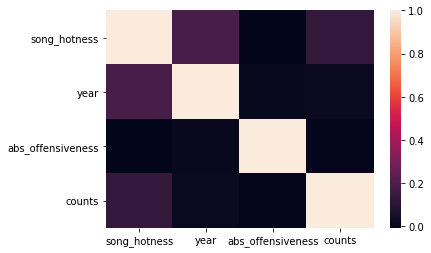

In [186]:
corr = off_hot_year.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Looking at the data directly

We don't see any immediate correlations in the data.
This can have many reasons.

 - Maybe we filtered in a bad way
 - Maybe the dependancy is not linear
 
Now we try to look at the "raw" data.

## Scatter years and offensiveness

This seems to show that songs become more offensive over time. The connection appears to be strong. But this scatter plot gives no true intuition for "density".

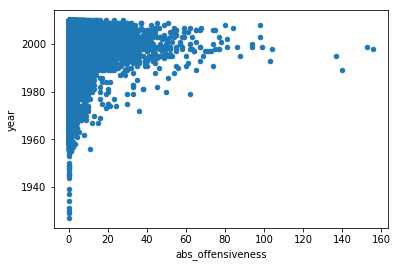

In [191]:
songs[songs["year"]>0].plot.scatter("abs_offensiveness", "year")

### Look at outliers
I've looked at the two strongest outliers, they are in fact rather offensive.

In [192]:
songs[songs["abs_offensiveness"]>150]

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts
366,TRBQEQL128F934092A,NaN,NaN,SOCHWTG12AB0182929,Don't Gimme No H.A.N./?,0,12851,166,38
16525,TRIZNAZ12903CA251C,NaN,NaN,SOMAYSH12AB0184269,Bitch Niggas,1999,69975,153,58
35579,TRORVNJ128F1453BEF,NaN,0.246865,SODSRNX12A6D4F72B2,Down For My N's,0,114683,153,65
48862,TRSLSAA128F930C4E6,NaN,0.711211,SOHLOTX12A6701FF2D,Gangster Tripping,1998,144126,156,3326


## Scatter offensiveness and play counts

This seems to show that play counts actually decrease with offensiveness.

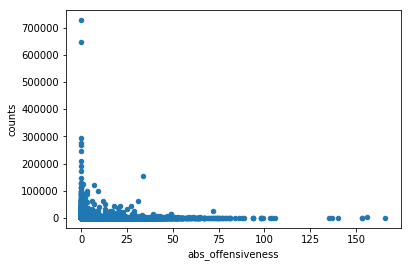

In [193]:
songs.plot.scatter("abs_offensiveness", "counts")

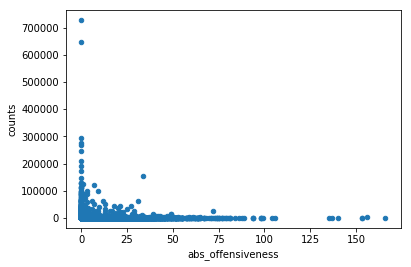

In [194]:
songs.query("counts > 1").plot.scatter("abs_offensiveness", "counts")

## Scatter offensiveness and hotness

We have to filter the hotness a lot.

This is actually the most interesting plot, I think.
It seems that "average" songs are the most offensive.

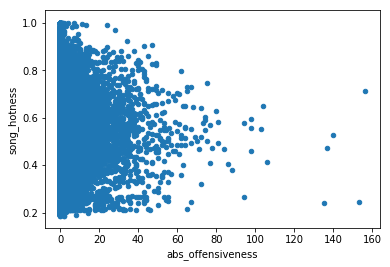

In [198]:
songs[["song_hotness", "abs_offensiveness"]]\
    .dropna()\
    .query("song_hotness > 0.1")\
    .plot.scatter("abs_offensiveness", "song_hotness")

## Looking at the correlations in detail

In [132]:
offensiveness_counts = songs[["abs_offensiveness", "counts"]]
offensiveness_counts.describe()

,abs_offensiveness,counts
count,123593.000000,123593.000000
mean,0.975646,539.790821
std,4.227654,4218.720423
min,0.000000,1.000000
25%,0.000000,15.000000
50%,0.000000,62.000000
75%,0.000000,266.000000
max,166.000000,726885.000000


In [133]:
offensiveness_counts.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.007951
counts,0.007951,1.000000


### Applying filtering and smoothing
Correlation is a very simple tool which only looks for linear dependancies. For the raw data, there is almost no correlation between offensiveness and play counts in the data.
We will now:
 - apply a variety of filtering operations to find correlations in subsets of the data.
 - try to smooth the data
 
None of the operations led to a significant increase in the correlation.

In [145]:
# smoothing the counts by using their log
offensiveness_counts_log = offensiveness_counts.copy()
offensiveness_counts_log["counts"] = offensiveness_counts_log["counts"].apply(lambda x : np.log(x))
offensiveness_counts_log.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.013263
counts,0.013263,1.000000


In [146]:
# looking only at songs that have been played often
offensiveness_counts_popular = offensiveness_counts_log.query("counts> 3")
offensiveness_counts_popular.corr()

,abs_offensiveness,counts
abs_offensiveness,1.00000,0.01551
counts,0.01551,1.00000


In [150]:
# looking only at recent songs
offensiveness_counts_recent = songs.query("year > 1990")[["abs_offensiveness", "counts"]]
offensiveness_counts_recent.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.005394
counts,0.005394,1.000000


In [151]:
# looking only at very recent songs
offensiveness_counts_very_recent = songs.query("year > 2000")[["abs_offensiveness", "counts"]]
offensiveness_counts_very_recent.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.007334
counts,0.007334,1.000000
